In [599]:
import os
import shap
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay, mean_absolute_error
from sklearn.inspection import permutation_importance

## Load data

In [600]:
current_dir = os.getcwd()
path = os.path.join(current_dir, '../data/clean', "merged_dataset_1.csv")
df = pd.read_csv(path)

In [601]:
# df = df[df["Year"] == 2012].copy()
# len(df)

## Select features

In [602]:
cols_to_drop = [
    'Well_ID', 'BRO-ID', 'geometry', 'Filter', 'Date', 'distance_m',
    'Unnamed: 0', 'Total Livestock', 'Excretion during grazing (million kg)', 'Municipal waste (1000 tonnes)/Total municipal waste (1 000 tonnes)',
    'Nitrogen losses in housing and storages/Total nitrogen losses (N) (million kg)',
    'Use of livestock manure in agriculture (million kg)', 'Mineral fertiliser N/ha in kg'
]

df = df.drop(columns=cols_to_drop, errors="ignore")

In [603]:
df['Landuse_Code'] = df['Landuse_Code'].fillna(-1).astype(int)

df['HGRnaam'] = df['HGRnaam'].astype("category")
df['Landuse_Code'] = df['Landuse_Code'].astype("category")
# df['Year'] = df['Landuse_Code'].astype("category")

In [604]:
df = df.dropna()
len(df)

191

## Remove nitrate outliers

In [605]:
q1 = df["Nitrate"].quantile(0.25)
q3 = df["Nitrate"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["Nitrate"] < lower_bound) | (df["Nitrate"] > upper_bound)]
print(f"Outliers found: {len(outliers)}")
outliers

Outliers found: 7


,Nitrate,avg_depth_m,Year,Population,HGRnaam,Landuse_Code,avg_temp_mean,avg_precip_sum,lon,lat,Elevation_m
54,28.79,5.087486,2012,65.0,zand,26,34.000000,1.50,5.441417,52.007418,8.548440
55,28.00,4.858125,2015,65.0,zand,-1,126.333333,6.50,5.441417,52.007418,8.548440
56,27.00,5.061042,2018,65.0,zand,23,122.883333,2.00,5.441417,52.007418,8.548440
70,29.37,6.838178,2012,40.0,zand,11,29.466667,8.75,5.600794,51.962454,12.048532
71,20.00,6.634271,2015,35.0,zand,-1,125.166667,1.00,5.600794,51.962454,12.048532
72,17.00,6.654944,2018,40.0,zand,27,115.566667,0.25,5.600794,51.962454,12.048532
78,17.00,9.291444,2018,55.0,zand,27,137.700000,6.00,5.546524,51.966980,16.680454


<Axes: >

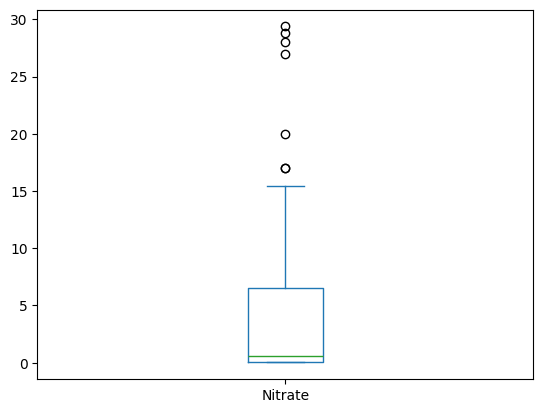

In [606]:
df[["Nitrate"]].plot(kind = "box")

In [607]:
# top_nitrate_outliers = list(df["Nitrate"].sort_values()[-len(outliers):].index)
# top_nitrate_outliers
# df = df.drop(top_nitrate_outliers)
# len(df)

## Preprocess data

In [608]:
categorical_cols = ["HGRnaam", "Landuse_Code"]
numerical_cols = [col for col in df.columns if col not in categorical_cols + ["Nitrate"]]

In [609]:
preprocessor = ColumnTransformer([
    ("cat_ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
], remainder="passthrough")

In [610]:
xgb_reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42
)

In [611]:
pipe = Pipeline([
    ("prep", preprocessor),
    ("xgb", xgb_reg)
])

## Test / Train split

In [612]:
X = df[categorical_cols + numerical_cols]
y = df["Nitrate"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

In [613]:
param_dist = {
    "xgb__n_estimators": [50, 100, 150],
    "xgb__max_depth": [2, 3, 5, 7],
    "xgb__learning_rate": [0.01, 0.05, 0.1],
    "xgb__subsample": [0.6, 0.8, 1.0],
    "xgb__colsample_bytree": [0.4, 0.6, 0.8]
}

## Hyperparameter tuning

In [614]:
search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring="r2",
    verbose=1,
    random_state=9,
    n_jobs=-1
)

In [615]:
search.fit(X_train, y_train)

print("Best CV R2:", search.best_score_)
print("Best params:", search.best_params_)

pred_nitrate = search.predict(X_test)
print("Test R2:", r2_score(y_test, pred_nitrate))
print("Test MAE:", mean_absolute_error(y_test, pred_nitrate))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV R2: 0.7024659383914131
Best params: {'xgb__subsample': 1.0, 'xgb__n_estimators': 150, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.05, 'xgb__colsample_bytree': 0.4}
Test R2: 0.7909049028626749
Test MAE: 1.720049679427193


<Axes: xlabel='Nitrate', ylabel='Nitrate'>

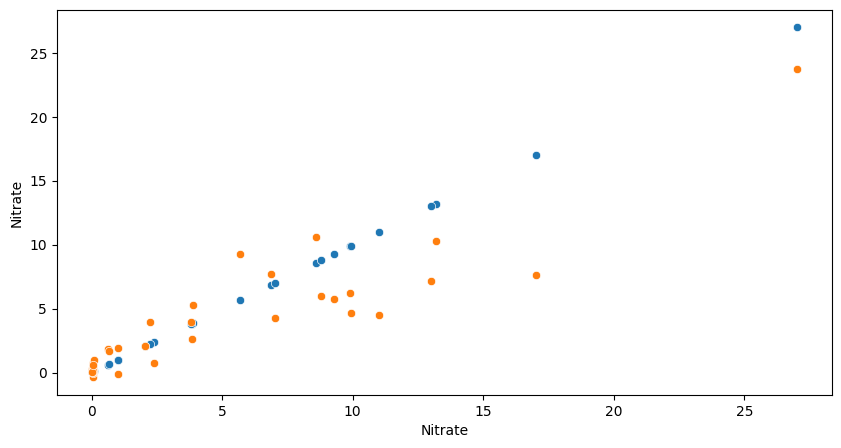

In [616]:
fix, ax = plt.subplots(figsize= (10,5))

sns.scatterplot(x = y_test, y = y_test, ax = ax)
sns.scatterplot(x = y_test, y = pred_nitrate, ax = ax)

Text(0, 0.5, 'Residuals')

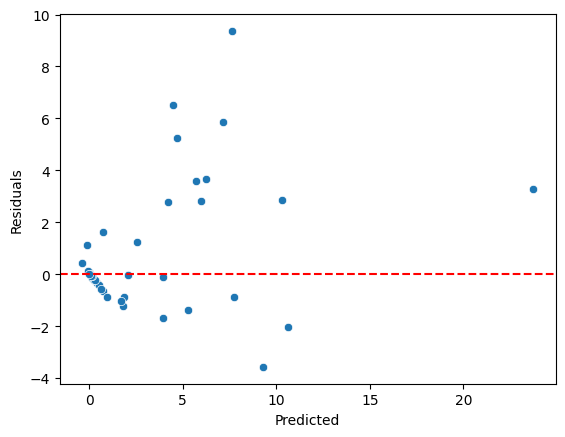

In [617]:
preds = search.predict(X_test)
residuals = y_test - preds
sns.scatterplot(x=preds, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted"); plt.ylabel("Residuals")

## Interpretability

In [618]:
best_pipe = search.best_estimator_
xgb_model = best_pipe.named_steps["xgb"]
feature_names = best_pipe.named_steps["prep"].get_feature_names_out()

### Default interpretability: Gain

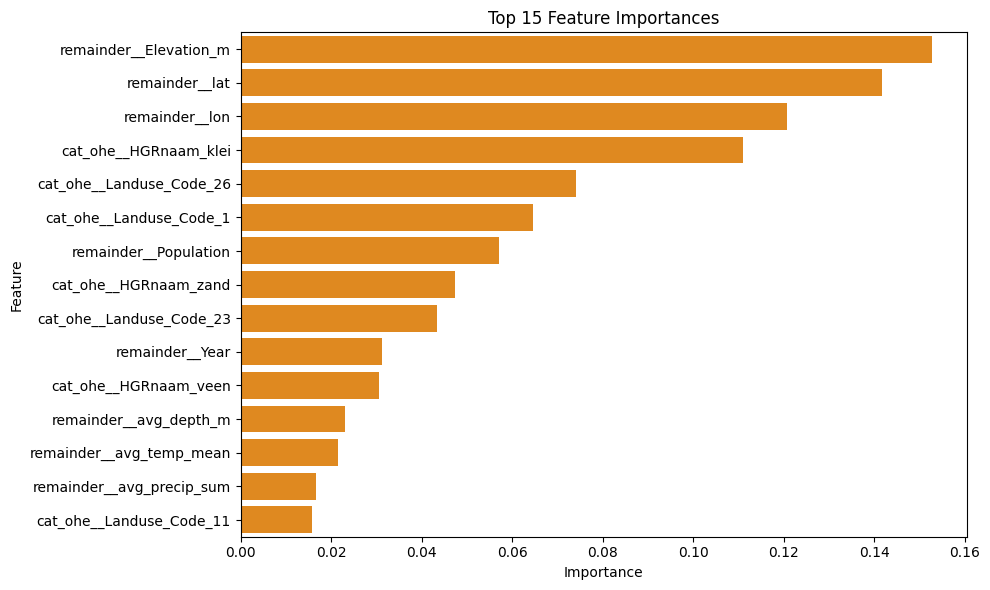

In [619]:
feature_names = best_pipe.named_steps["prep"].get_feature_names_out()

importances = xgb_model.feature_importances_

fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=fi_df.head(15), color="darkorange")
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

In [620]:
booster = xgb_model.get_booster()

feature_map = {f"f{i}": name for i, name in enumerate(feature_names)}

importance_types = ["gain", "cover", "weight"]
importance_data = []

for imp_type in importance_types:
    imp_dict = booster.get_score(importance_type=imp_type)
    for fx, val in imp_dict.items():
        importance_data.append({
            "Feature": feature_map.get(fx, fx), #here we map f1, f2, etc with real feature names
            "Importance": val,
            "Type": imp_type
        })

In [621]:
# convert list of dictionaries to pandas df
importances_df = pd.DataFrame(importance_data)

# normalize the feature importances within each importance type
# divide every value in that group by the total sum of the group
# so it always ranges between (0 - 1)
importances_df["Importance"] = importances_df.groupby("Type")["Importance"].transform(lambda x: x / x.sum())

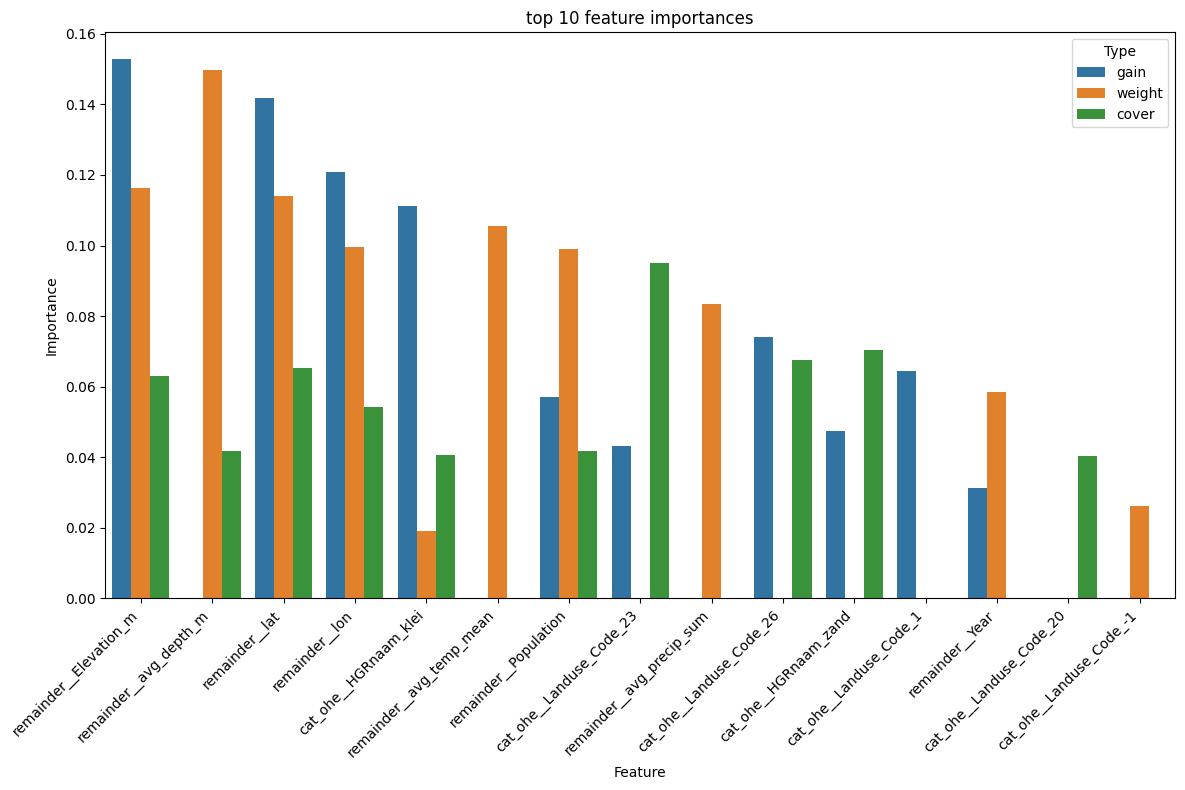

In [622]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=importances_df.sort_values("Importance", ascending=False).groupby("Type").head(10),
    x="Feature",
    y="Importance",
    hue="Type"
)
plt.xticks(rotation=45, ha='right')
plt.title("top 10 feature importances")
plt.tight_layout()
plt.show()


# Model-agnostic interpretability

In [623]:
feature_names = best_pipe.named_steps["prep"].get_feature_names_out()
X_test_transformed = best_pipe.named_steps["prep"].transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

## Permutation

In [624]:
result = permutation_importance(
    estimator=best_pipe.named_steps["xgb"],  # just the model
    X=X_test_transformed,
    y=y_test,
    n_repeats=30,
    random_state=42,
    scoring="r2",
    n_jobs=-1
)

perm_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": result.importances_mean,
    "Type": "permutation"
})

perm_df["Importance"] /= perm_df["Importance"].sum()

combined_df = pd.concat([importances_df, perm_df], axis=0)

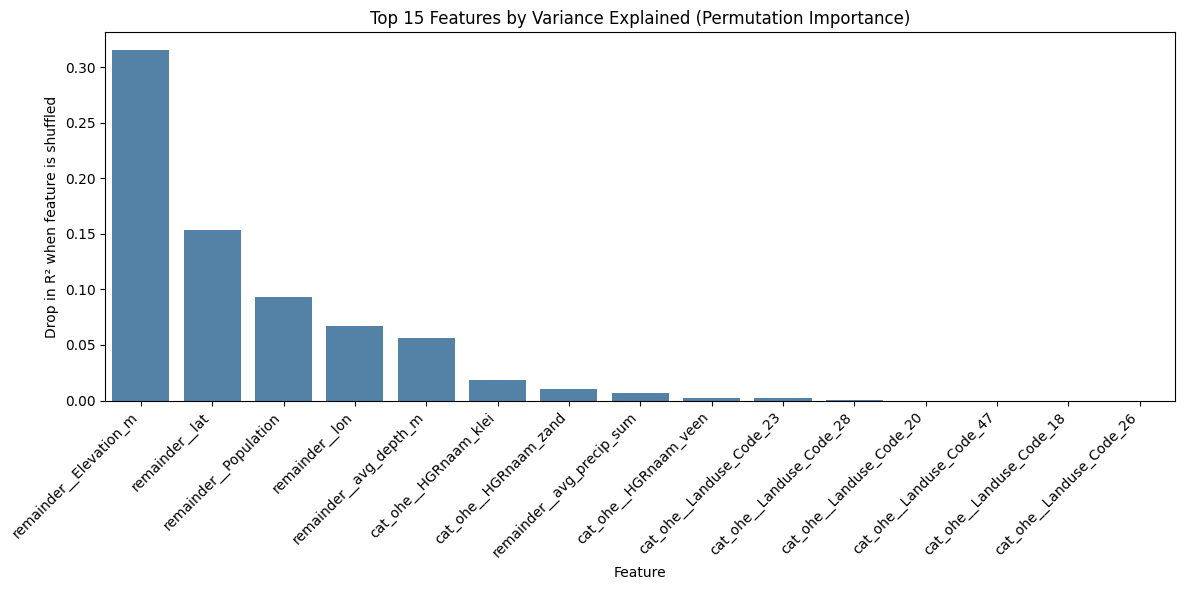

In [629]:
perm_df_raw = pd.DataFrame({
    "Feature": feature_names,
    "Importance": result.importances_mean,
    "Std": result.importances_std
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=perm_df_raw.head(10),
    x="Feature",
    y="Importance",
    color="steelblue"
)
plt.xticks(rotation=45, ha="right")
plt.title("permutation importance)")
plt.ylabel("Drop in R2 when feature is shuffled")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=perm_df.head(15), x="Feature", y="Importance", color="cadetblue")
plt.xticks(rotation=45, ha="right")
plt.title("Top 15 Feature Importances (Permutation Test)")
plt.tight_layout()
plt.show()

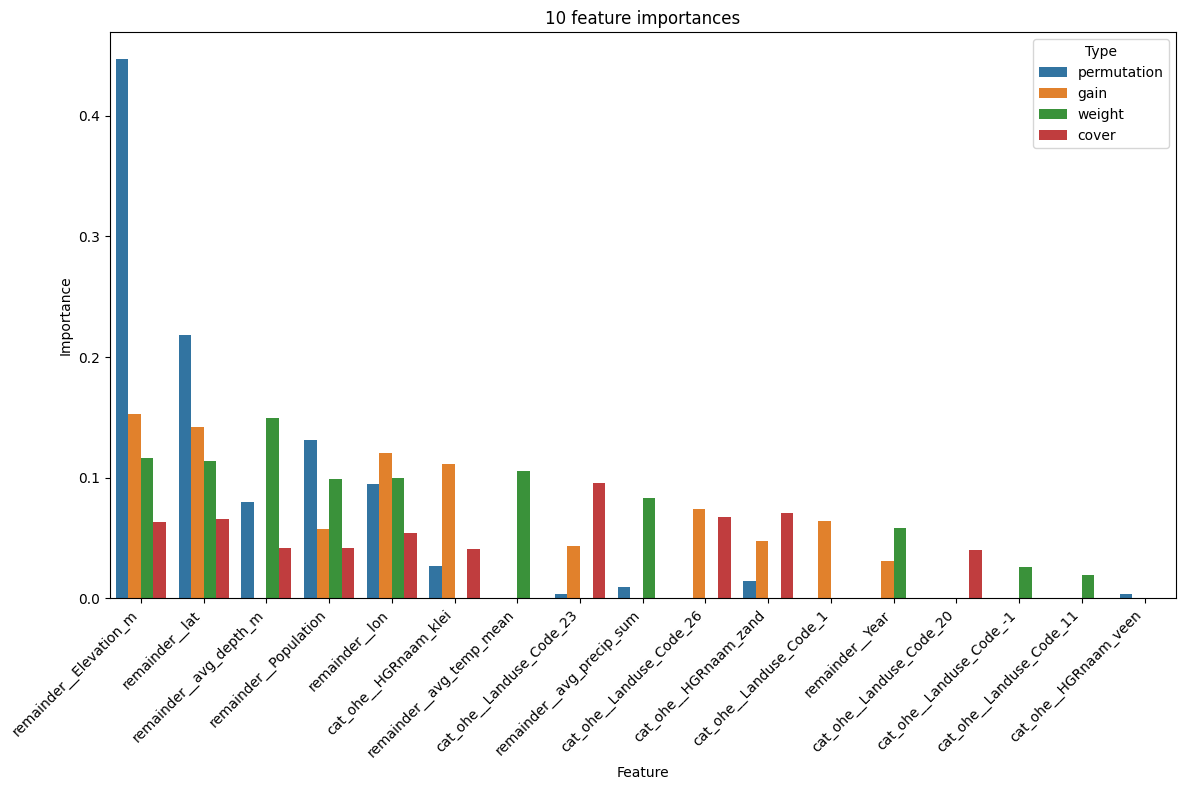

In [626]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=combined_df.sort_values("Importance", ascending=False).groupby("Type").head(10),
    x="Feature",
    y="Importance",
    hue="Type"
)
plt.xticks(rotation=45, ha='right')
plt.title("10 feature importances")
plt.tight_layout()
plt.show()

## Tree SHAP

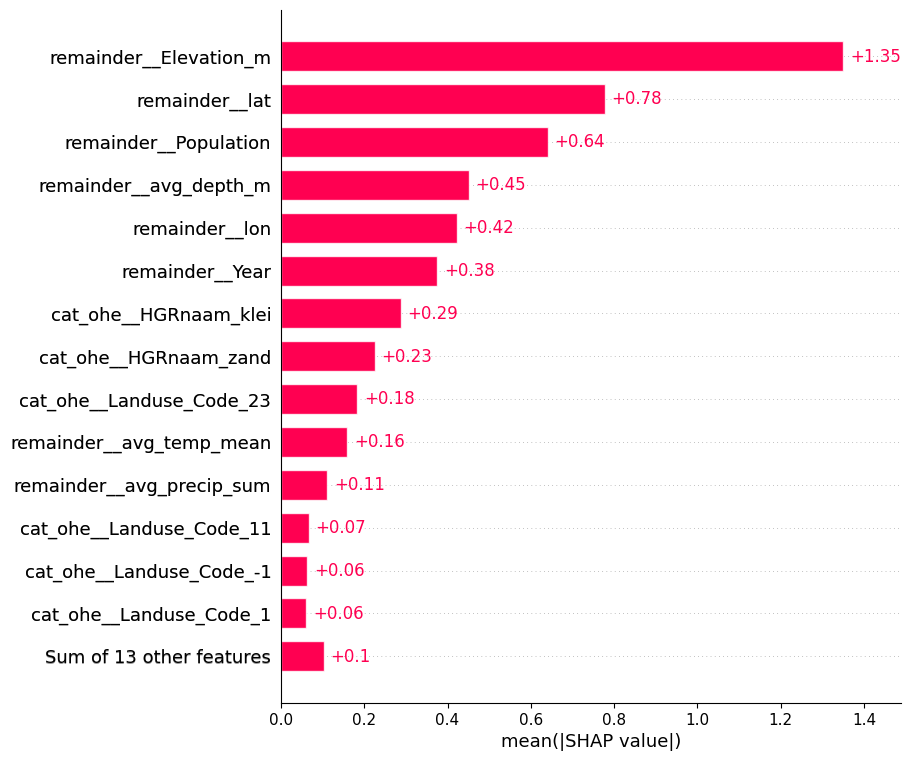

In [627]:
explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer.shap_values(X_test_transformed_df)

shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test_transformed_df.values,
    feature_names=X_test_transformed_df.columns
)

shap.plots.bar(shap_explanation, max_display=15)

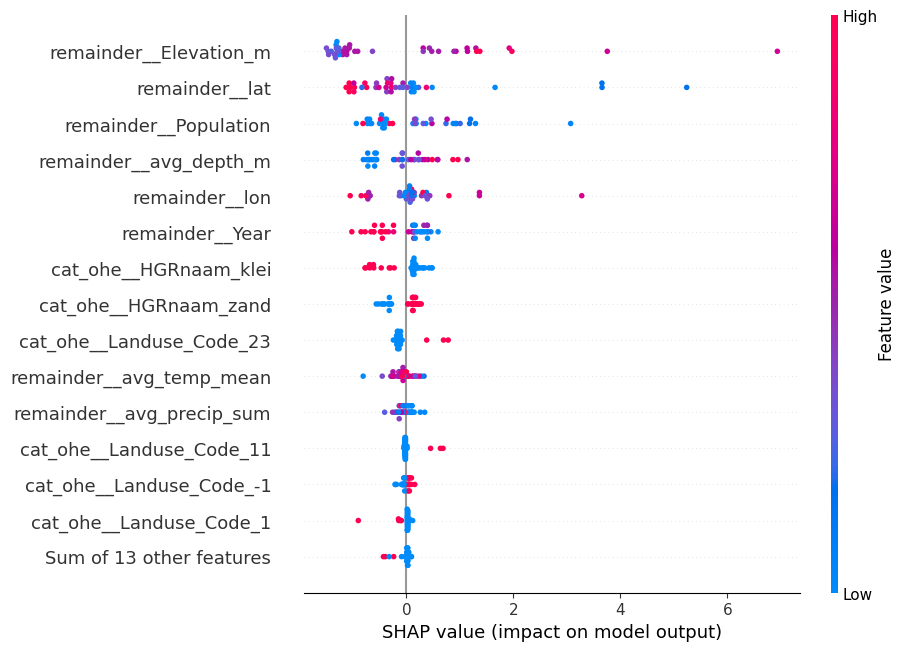

In [628]:
shap.plots.beeswarm(shap_explanation, max_display=15)